In [3]:
import sys
# necessary to find ros packages
sys.path.append('/opt/ros/humble/local/lib/python3.10/dist-packages')

import numpy as np
import matplotlib.pyplot as plt
import yaml

from models.point import Point, RefPoint
from models.map import Map
from models.pose import Pose
from utils.classify_points import classify_points
from utils.extract_track_borders import extract_track_borders
from utils.get_center_line import get_center_line
from utils.trajectory_from_points import trajectory_from_path
import math

from path_find_algorithms.A_star.A_star import AStar
import csv

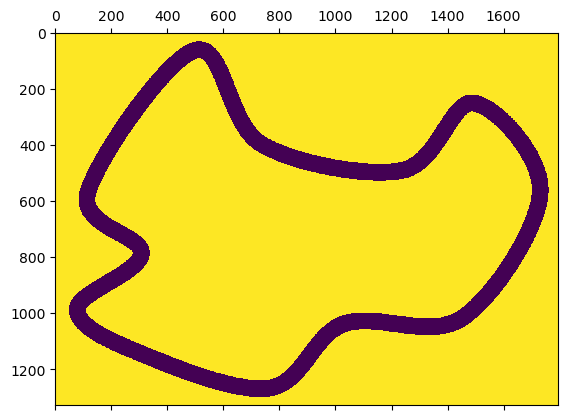

In [4]:
with open('../../../to_be_saved/tracks/track_3/costmap/map.npy', 'rb') as f:
    occupancy_grid = np.load(f)

with (open('../../../to_be_saved/tracks/track_3/costmap/map.yaml', 'rb')) as f:
    occupancy_grid_config = yaml.safe_load(f)

occupancy_grid = (occupancy_grid != 0) * 1
plt.matshow(occupancy_grid)

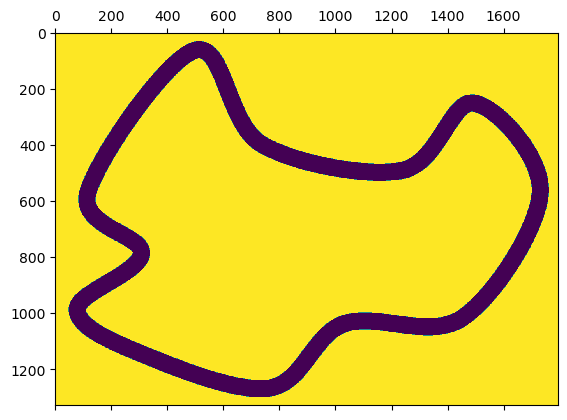

In [9]:
point_inside_track = Point(330, 200)
assert occupancy_grid[point_inside_track.y, point_inside_track.x] == 0

classified_grid = classify_points(point_inside_track, occupancy_grid)

plt.matshow(classified_grid)

# For some reason the maps come with an resolution offset
resolution = occupancy_grid_config["resolution"]
classification_map = Map(classified_grid, resolution, Point(occupancy_grid_config["origin_x"] - resolution, occupancy_grid_config["origin_y"] -resolution))

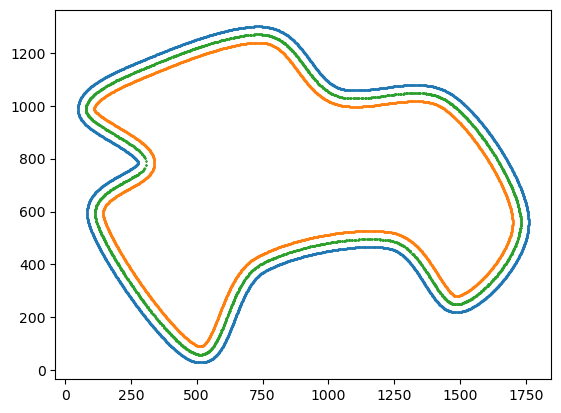

In [10]:
track_borders = extract_track_borders(classification_map.grid)
assert len(track_borders) == 2
center_line = get_center_line(track_borders[0], track_borders[1])

for line in [*track_borders, center_line]:
    plt.scatter([p.x for p in line], [p.y for p in line], s=0.1)

In [37]:
from scipy import interpolate
from scipy import ndimage

def smooth_path(path: list[Point], window_size=10, limit_factor=2, interpolation_steps=1000):
    points = np.empty(shape=(len(path), 2))
    for i, point in enumerate(path):
        points[i] = [point.x, point.y]

    # remove duplicates from trajectory
    _, idx = np.unique(points, axis=0, return_index=True)
    uniques = points[np.sort(idx)]

    x = uniques[:,0]
    y = uniques[:,1]

    # smooth trajectory
    jump = np.sqrt(np.diff(x)**2 + np.diff(y)**2) 
    smooth_jump = ndimage.gaussian_filter1d(jump, window_size, mode='wrap')  # window of size 5 is arbitrary
    limit = limit_factor*np.median(smooth_jump)    # factor 2 is arbitrary
    x_smoothed, y_smoothed = x[:-1], y[:-1]
    x_smoothed = x_smoothed[(jump > 0) & (smooth_jump < limit)]
    y_smoothed = y_smoothed[(jump > 0) & (smooth_jump < limit)]

    x_smoothed = np.r_[x_smoothed, x[-1]]
    y_smoothed = np.r_[y_smoothed, y[-1]]
    



    tck, u = interpolate.splprep([x_smoothed,y_smoothed], per=True)
    x_int, y_int = interpolate.splev(np.linspace(0,1, interpolation_steps), tck)
    trajectory_smoothed = [Point(int(x),int(y)) for (x,y) in zip(x_int, y_int)]
    trajectory_smoothed.append(trajectory_smoothed[0])
    return trajectory_smoothed
    

/usr/lib/python3/dist-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][3799]=x[0][0]
  warnings.warn(RuntimeWarning('Setting x[%d][%d]=x[%d][0]' %
/usr/lib/python3/dist-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][3799]=x[1][0]
  warnings.warn(RuntimeWarning('Setting x[%d][%d]=x[%d][0]' %


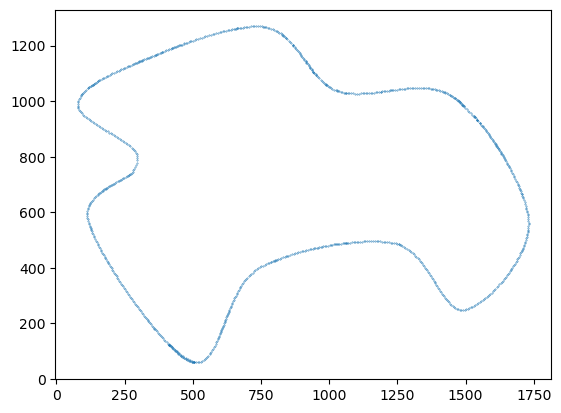

In [38]:
trajectory_smoothed = smooth_path(center_line, window_size=10)
plt.scatter([p.x for p in trajectory_smoothed], [p.y for p in trajectory_smoothed], s=0.1)
#trajectory_smoothed = smooth_path(center_line, window_size=10)
#plt.scatter([p.x for p in trajectory_smoothed], [p.y for p in trajectory_smoothed], s=0.1)

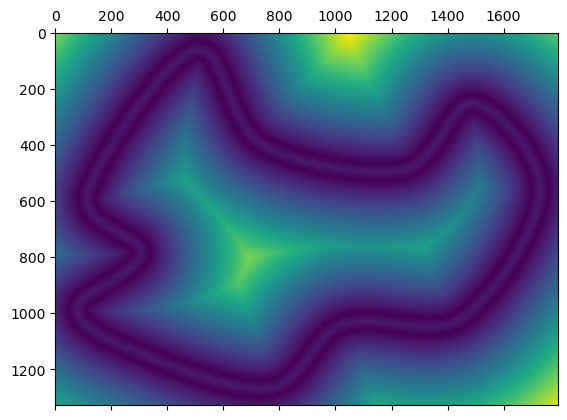

In [43]:
from scipy import ndimage
binarized_grid = classification_map.grid != 2
distances = ndimage.distance_transform_edt(binarized_grid)
plt.matshow(distances)

[1 2 3]


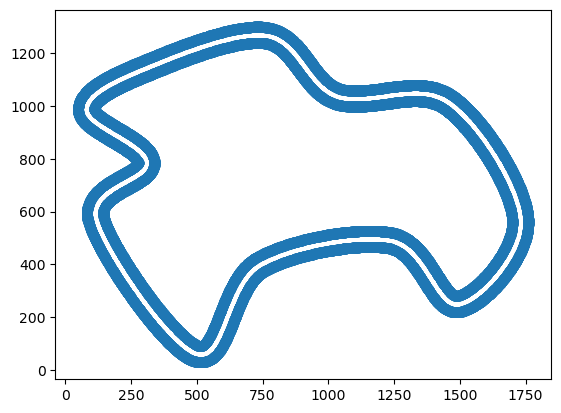

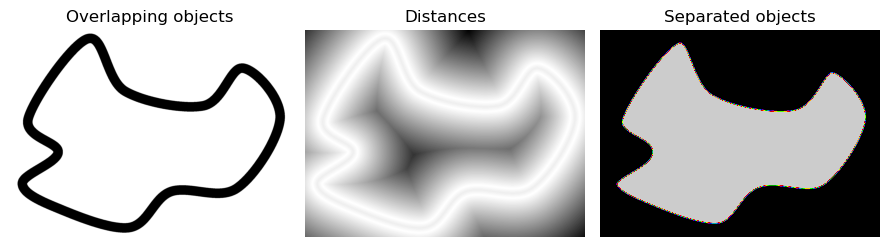

In [73]:
from skimage.segmentation import watershed
from skimage.feature import peak_local_max

coords = peak_local_max(-distances, footprint=np.ones((3, 3)), labels=classification_map.grid)
plt.scatter([coord[1] for coord in coords], [coord[0] for coord in coords])
mask = np.zeros(distances.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers, _ = ndimage.label(mask)
labels = watershed(-distances, markers, mask=classification_map.grid)
print(np.unique(classification_map.grid))

fig, axes = plt.subplots(ncols=3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(classification_map.grid, cmap=plt.cm.gray)
ax[0].set_title('Overlapping objects')
ax[1].imshow(-distances, cmap=plt.cm.gray)
ax[1].set_title('Distances')
ax[2].imshow(labels, cmap=plt.cm.nipy_spectral)
ax[2].set_title('Separated objects')

for a in ax:
    a.set_axis_off()

fig.tight_layout()
plt.show()

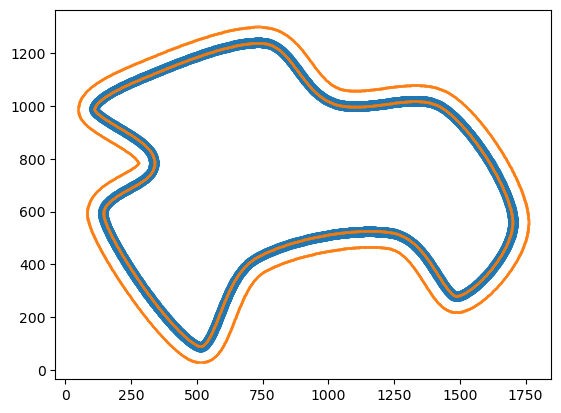

In [77]:
from skimage import measure
contours = measure.find_contours(labels, 1)[0]
plt.scatter([coord[1] for coord in contours], [coord[0] for coord in contours])
plt.scatter([coord[1] for coord in coords], [coord[0] for coord in coords], s=0.01)

In [52]:
path_with_widths = []

for point in trajectory_smoothed:
    distance = distances[point.y, point.x]
    path_with_widths.append(RefPoint(point.x, point.y, distance, distance))


In [41]:
header = ['x_m', 'y_m', 'w_tr_right_m', 'w_tr_left_m']

with open('../../../to_be_saved/tracks/track_3/center_line.csv', 'w', encoding='UTF8', newline='') as f:
    path_world_coordinates = list(map(lambda point: classification_map.grid_point_to_world_point(
        point), path_with_widths))
    
    header_str = "# "
    for word in header[:-1]:
        header_str += word +","
    header_str += header[-1]
    f.write(f"{header_str}\n")

    writer = csv.writer(f)
    path_world_coords_reformatted = list(map(lambda point: [point.x, point.y, point.w_tr_right, point.w_tr_left], path_world_coordinates))
    writer.writerows(path_world_coords_reformatted)